# Discrete Dynamic Obstacles Environment
This section includes the implementation of a custom Gym environment with dynamic obstacles in a grid. The environment supports discrete actions.

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Custom Environment
class DynamicObstaclesEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, n_obstacles=3):
        super(DynamicObstaclesEnv, self).__init__()
        self.grid_size = grid_size
        self.n_obstacles = n_obstacles
        self.action_space = spaces.Discrete(4)  # Up, down, left, right
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size, 1), dtype=np.float32)
        self.goal = [grid_size - 1, grid_size - 1]
        self.states = []  # Store states for post-episode visualization
        self.reset()

    def reset(self):
        self.agent_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
        while self.agent_pos == self.goal:
            self.agent_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
        self.obstacles = []
        for _ in range(self.n_obstacles):
            obs_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            while obs_pos in self.obstacles or obs_pos == self.agent_pos or obs_pos == self.goal:
                obs_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            self.obstacles.append(obs_pos)
        self.states = [self._get_grid()]
        return self._next_observation()

    def _next_observation(self):
        obs = np.zeros((self.grid_size, self.grid_size, 1), dtype=np.float32)
        obs[self.agent_pos[0], self.agent_pos[1], 0] = 1  # Agent position
        for obs_pos in self.obstacles:
            obs[obs_pos[0], obs_pos[1], 0] = 0.5  # Obstacle position
        obs[self.goal[0], self.goal[1], 0] = 1  # Goal position
        return obs

    def step(self, action):
        # Apply action
        if action == 0:  # Up
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == 1:  # Down
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)
        elif action == 2:  # Left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 3:  # Right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)

        # Move obstacles
        for obs_pos in self.obstacles:
            move = random.choice([(1, 0), (-1, 0), (0, 1), (0, -1)])
            obs_pos[0] = max(0, min(self.grid_size - 1, obs_pos[0] + move[0]))
            obs_pos[1] = max(0, min(self.grid_size - 1, obs_pos[1] + move[1]))

        reward = -1  # Default reward
        done = False
        info = {}

        # Check if the agent reached the goal
        if self.agent_pos == self.goal:
            reward = 100
            done = True

        # Check if the agent hit an obstacle
        if self.agent_pos in self.obstacles:
            reward = -100
            done = True

        return self._next_observation(), reward, done, info

    def _get_grid(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.agent_pos[0], self.agent_pos[1]] = 1
        grid[self.goal[0], self.goal[1]] = 2
        for obs in self.obstacles:
            grid[obs[0], obs[1]] = 3
        return grid

    def render(self, mode='rgb_array'):
            if mode == 'rgb_array':
                # Create an image with a white background
                image = np.ones((self.grid_size, self.grid_size, 3), dtype=np.uint8) * 255

                # Draw grid lines
                for i in range(self.grid_size):
                    for j in range(self.grid_size):
                        image[i, j] = [200, 200, 200] if (i + j) % 2 == 0 else [255, 255, 255]

                # Represent the agent, goal, and obstacles with different colors
                image[self.agent_pos[0], self.agent_pos[1]] = [255, 0, 0]  # Red for agent
                image[self.goal[0], self.goal[1]] = [0, 255, 0]  # Green for goal
                for obs in self.obstacles:
                    image[obs[0], obs[1]] = [0, 0, 255]  # Blue for obstacles

                return image

            else:
                super(DynamicObstaclesEnv, self).render(mode=mode)  # Just to adhere to Gym's interface

# Continuous Dynamic Obstacles Environment
This part focuses on a variation of the environment that supports continuous actions.

In [ ]:
import gym
from gym import spaces
import numpy as np
import random

class DynamicObstaclesEnvCont(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, n_obstacles=3, max_step_size=1.0):
        super(DynamicObstaclesEnvCont, self).__init__()
        self.grid_size = grid_size
        self.n_obstacles = n_obstacles
        self.max_step_size = max_step_size

        # Define a 2D continuous action space: [movement angle, movement distance]
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2*np.pi, max_step_size]), dtype=np.float32)

        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size, 1), dtype=np.float32)
        self.goal = [grid_size - 1, grid_size - 1]
        self.states = []
        self.reset()

    def reset(self):
        self.agent_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
        while self.agent_pos == self.goal:
            self.agent_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
        self.obstacles = []
        for _ in range(self.n_obstacles):
            obs_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            while obs_pos in self.obstacles or obs_pos == self.agent_pos or obs_pos == self.goal:
                obs_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            self.obstacles.append(obs_pos)
        self.states = [self._get_grid()]
        return self._next_observation()

    def step(self, action):
        # Interpret continuous action
        # Example: action[0] is horizontal movement, action[1] is vertical movement
        dx = np.clip(action[0], -1, 1)  # Assuming action values are normalized between -1 and 1
        dy = np.clip(action[1], -1, 1)

        # Update agent's position
        self.agent_pos[0] = np.clip(self.agent_pos[0] + int(dx), 0, self.grid_size - 1)
        self.agent_pos[1] = np.clip(self.agent_pos[1] + int(dy), 0, self.grid_size - 1)


        # Move obstacles
        for obs_pos in self.obstacles:
            move = random.choice([(1, 0), (-1, 0), (0, 1), (0, -1)])
            obs_pos[0] = max(0, min(self.grid_size - 1, obs_pos[0] + move[0]))
            obs_pos[1] = max(0, min(self.grid_size - 1, obs_pos[1] + move[1]))

        reward = -1  # Default reward
        done = False
        info = {}

        # Check if the agent reached the goal
        if self.agent_pos == self.goal:
            reward = 100
            done = True

        # Check if the agent hit an obstacle
        if self.agent_pos in self.obstacles:
            reward = -100
            done = True


        return self._next_observation(), reward, done, info

    def _get_grid(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.agent_pos[0], self.agent_pos[1]] = 1
        grid[self.goal[0], self.goal[1]] = 2
        for obs in self.obstacles:
            grid[obs[0], obs[1]] = 3
        return grid

    def _next_observation(self):
        obs = np.zeros((self.grid_size, self.grid_size, 1), dtype=np.float32)
        obs[self.agent_pos[0], self.agent_pos[1], 0] = 1  # Agent position
        for obs_pos in self.obstacles:
            obs[obs_pos[0], obs_pos[1], 0] = 0.5  # Obstacle position
        obs[self.goal[0], self.goal[1], 0] = 1  # Goal position
        return obs


    def render(self, mode='rgb_array'):
            if mode == 'rgb_array':
                # Create an image with a white background
                image = np.ones((self.grid_size, self.grid_size, 3), dtype=np.uint8) * 255

                # Draw grid lines
                for i in range(self.grid_size):
                    for j in range(self.grid_size):
                        image[i, j] = [200, 200, 200] if (i + j) % 2 == 0 else [255, 255, 255]

                # Represent the agent, goal, and obstacles with different colors
                image[self.agent_pos[0], self.agent_pos[1]] = [255, 0, 0]  # Red for agent
                image[self.goal[0], self.goal[1]] = [0, 255, 0]  # Green for goal
                for obs in self.obstacles:
                    image[obs[0], obs[1]] = [0, 0, 255]  # Blue for obstacles

                return image

            else:
                super(DynamicObstaclesEnv, self).render(mode=mode)  # Just to adhere to Gym's interface



# Deep Q-Network (DQN) Implementation
Hyperparameter Tuning for DQN
This section includes the process of tuning hyperparameters for the DQN algorithm.

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# Assuming DynamicObstaclesEnv is defined as per your earlier description

# Create the custom environment
env = make_vec_env(lambda: DynamicObstaclesEnv(grid_size=10, n_obstacles=3), n_envs=1)

# Hyperparameters to try
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]
buffer_sizes = [10000, 50000, 100000]  # Replay buffer sizes

best_performance = -float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for buffer_size in buffer_sizes:
            # Initialize the DQN model with specified hyperparameters
            model = DQN("MlpPolicy", env, learning_rate=lr, batch_size=batch_size, buffer_size=buffer_size, verbose=0)
            model.learn(total_timesteps=20000)

            # Evaluate the model
            mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
            print(f"LR: {lr}, Batch Size: {batch_size}, Buffer Size: {buffer_size}, Mean Reward: {mean_reward}")

            # Check if this is the best performing model
            if mean_reward > best_performance:
                best_performance = mean_reward
                best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size, 'buffer_size': buffer_size}

# Output the best hyperparameters
print(f"Best Hyperparameters: {best_hyperparameters}")

# Save the best performing model
model.save("dqn_dynamic_obstacles_best")


LR: 0.001, Batch Size: 32, Buffer Size: 10000, Mean Reward: -175.1
LR: 0.001, Batch Size: 32, Buffer Size: 50000, Mean Reward: -209.2
LR: 0.001, Batch Size: 32, Buffer Size: 100000, Mean Reward: -213.5
LR: 0.001, Batch Size: 64, Buffer Size: 10000, Mean Reward: -146.0
LR: 0.001, Batch Size: 64, Buffer Size: 50000, Mean Reward: -190.3
LR: 0.001, Batch Size: 64, Buffer Size: 100000, Mean Reward: -263.5
LR: 0.001, Batch Size: 128, Buffer Size: 10000, Mean Reward: -177.8
LR: 0.001, Batch Size: 128, Buffer Size: 50000, Mean Reward: -229.8
LR: 0.001, Batch Size: 128, Buffer Size: 100000, Mean Reward: -181.0
LR: 0.0005, Batch Size: 32, Buffer Size: 10000, Mean Reward: -108.9
LR: 0.0005, Batch Size: 32, Buffer Size: 50000, Mean Reward: -81.4
LR: 0.0005, Batch Size: 32, Buffer Size: 100000, Mean Reward: -159.3
LR: 0.0005, Batch Size: 64, Buffer Size: 10000, Mean Reward: -252.5
LR: 0.0005, Batch Size: 64, Buffer Size: 50000, Mean Reward: -267.8
LR: 0.0005, Batch Size: 64, Buffer Size: 100000, Me

# Model Evaluation and Visualization
Here, the trained DQN model is evaluated and visualized.

Average Cumulative Reward: -173.83
Success Rate: 0.07


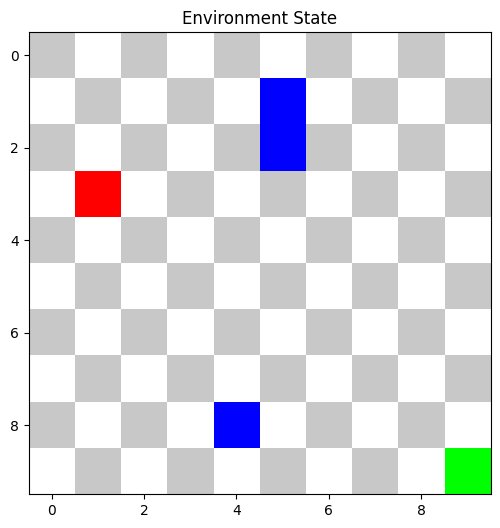

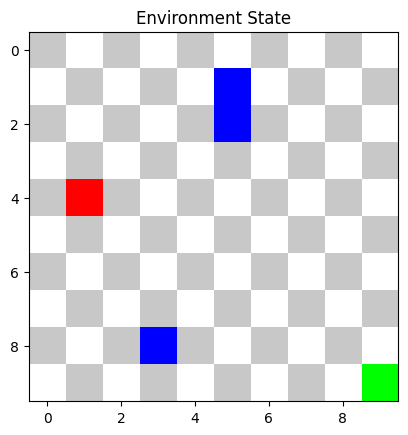

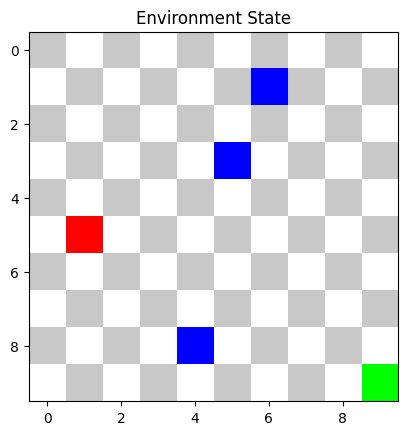

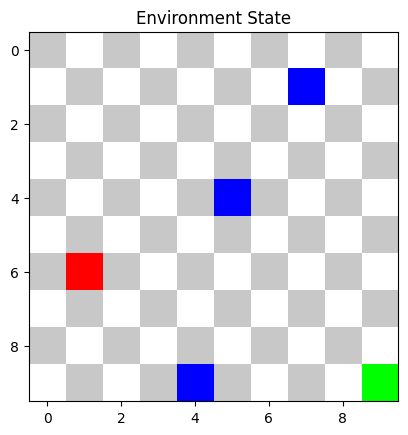

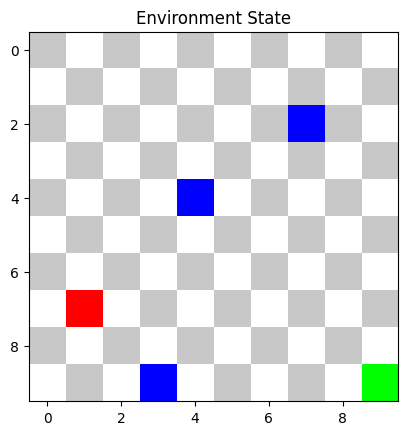

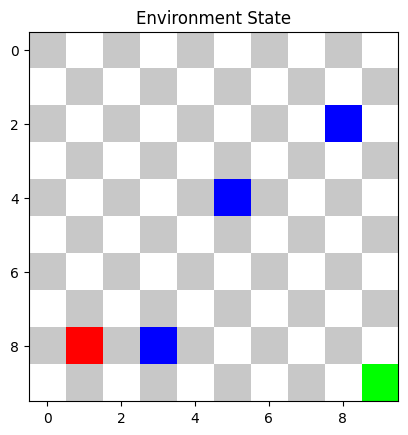

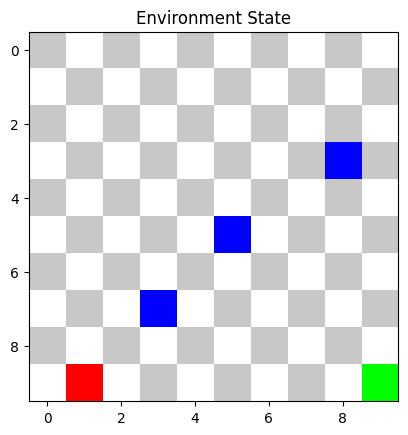

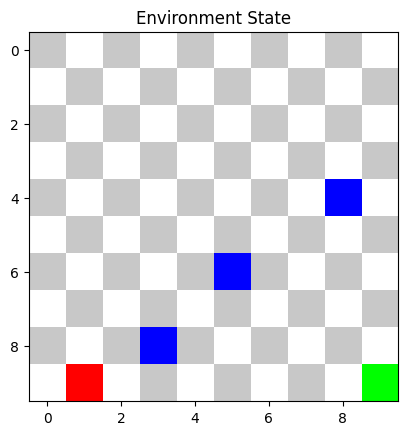

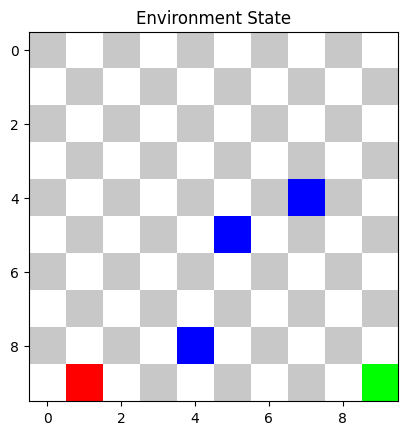

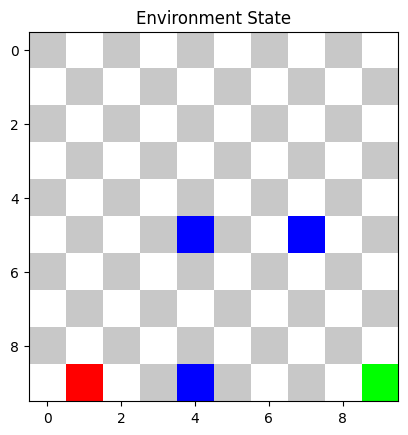

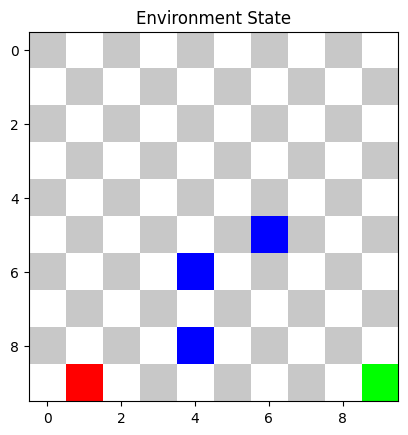

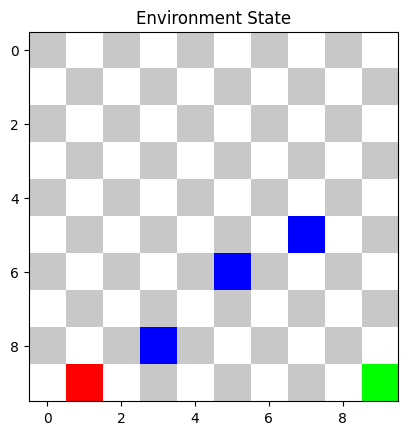

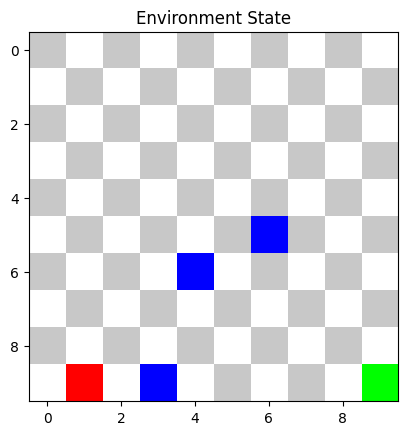

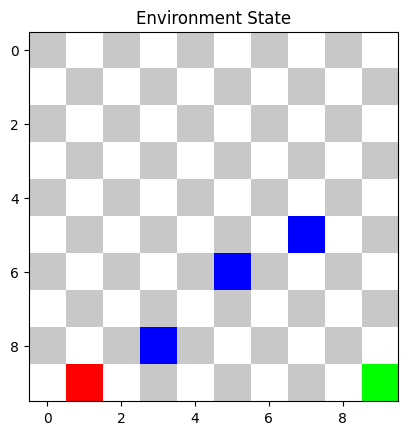

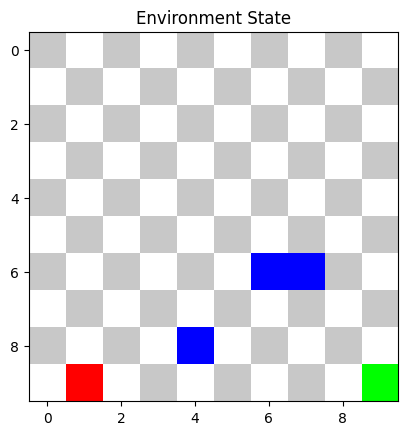

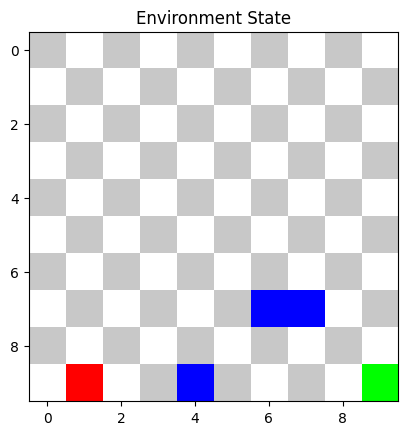

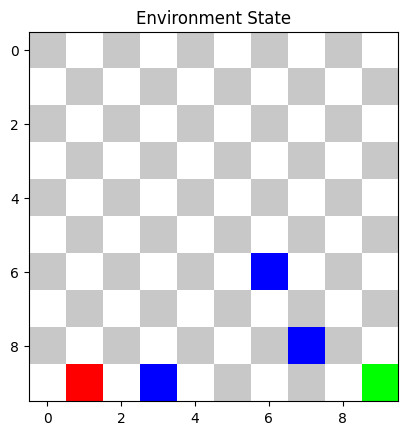

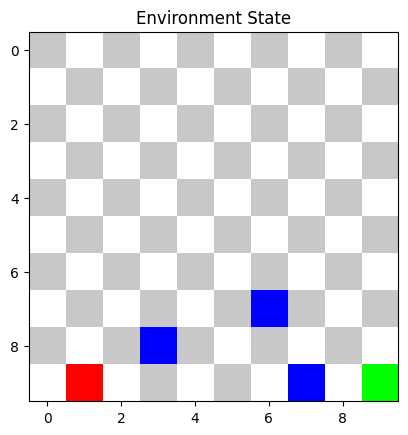

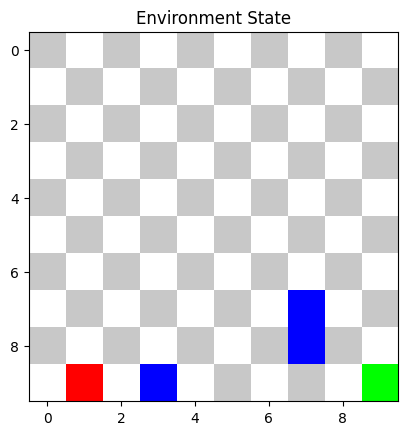

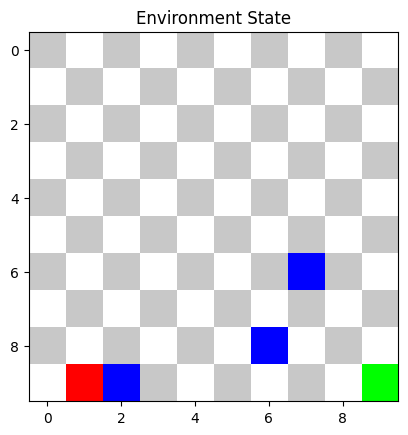

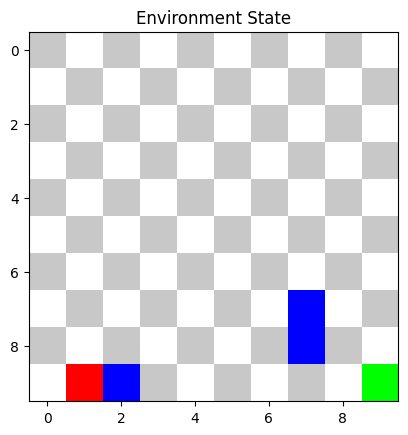

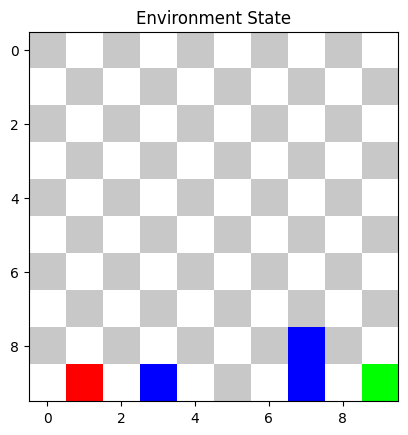

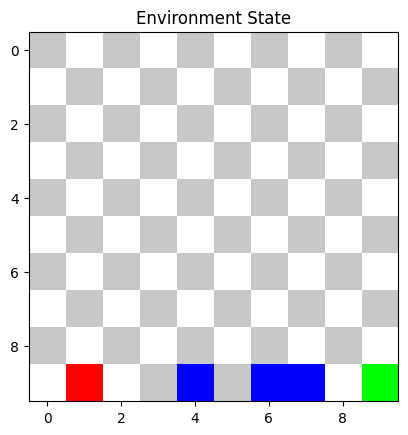

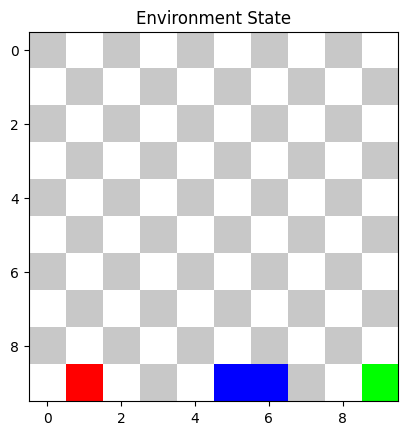

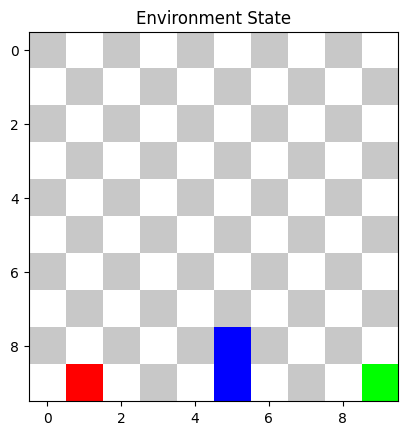

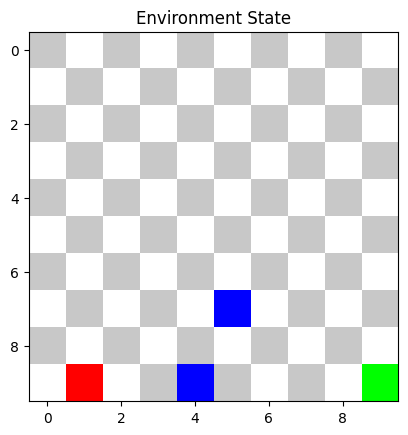

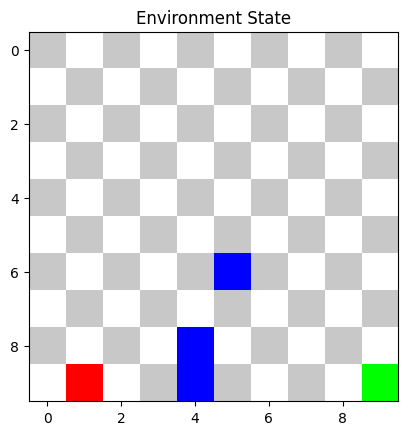

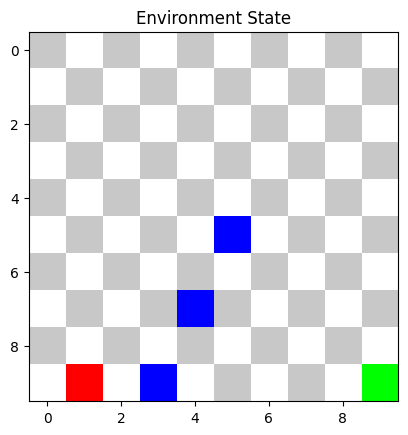

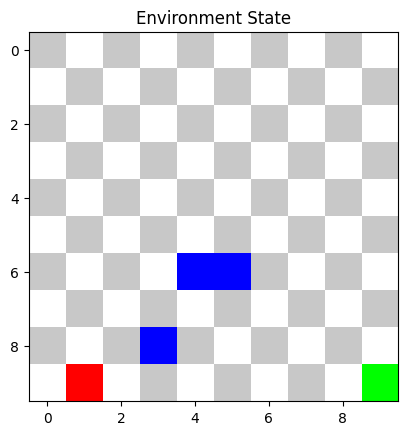

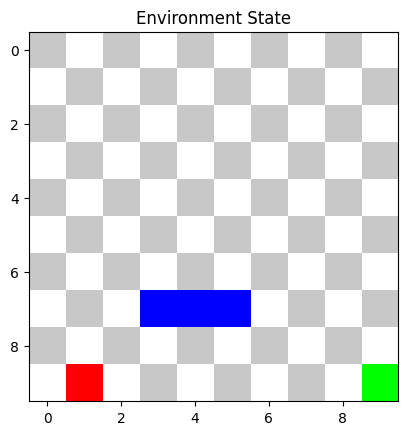

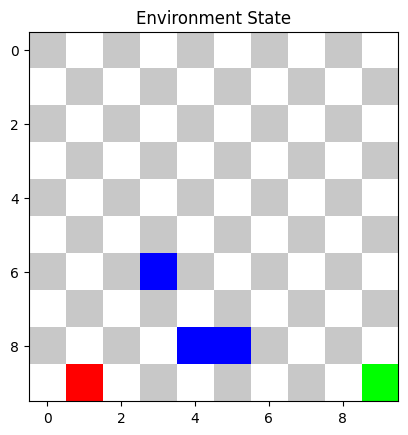

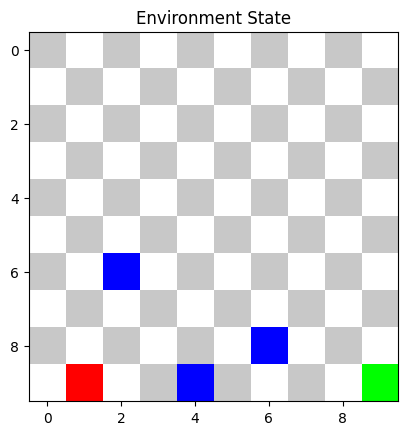

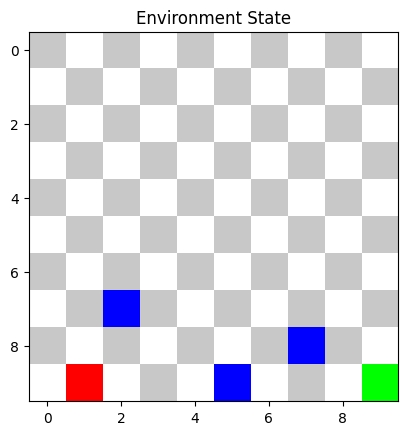

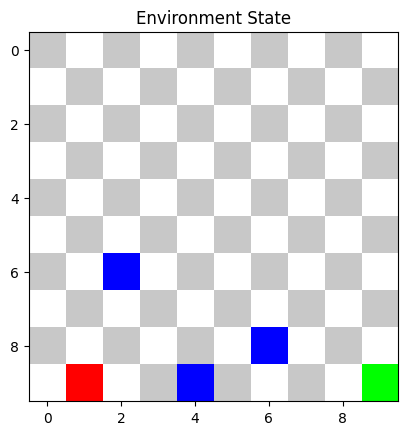

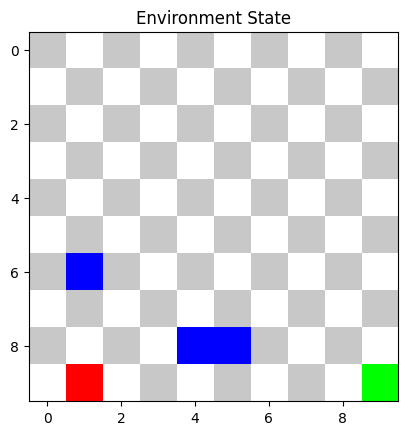

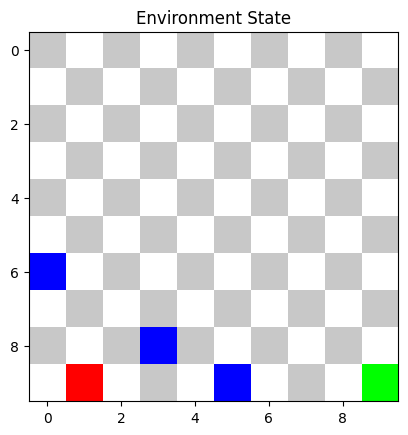

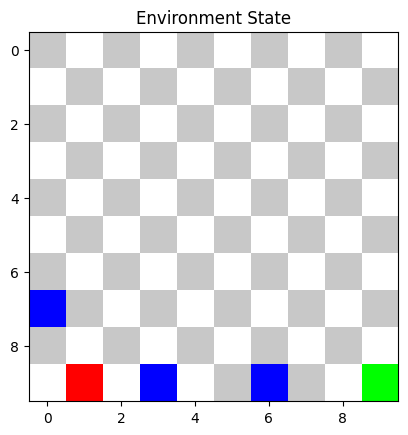

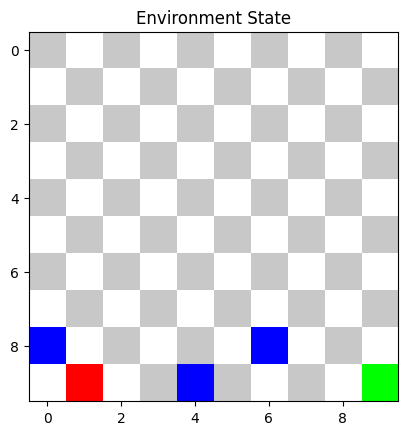

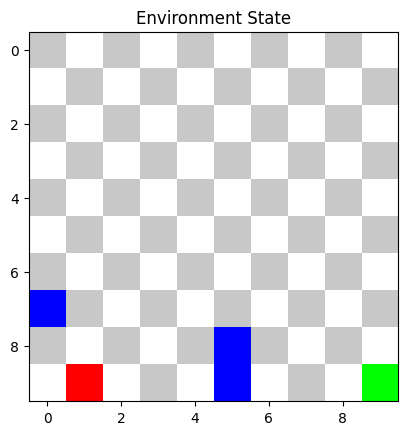

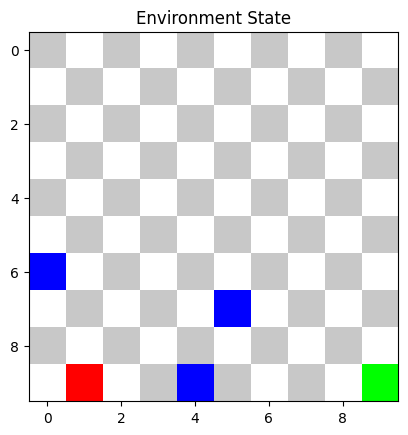

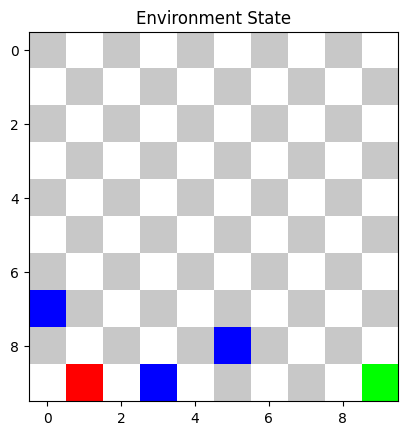

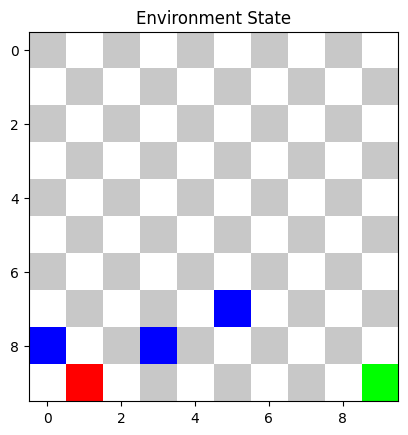

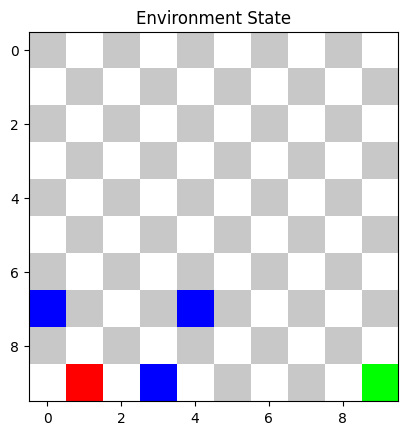

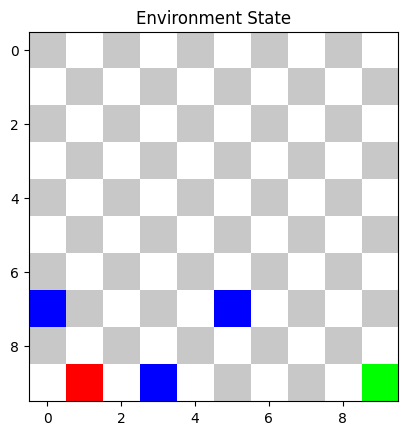

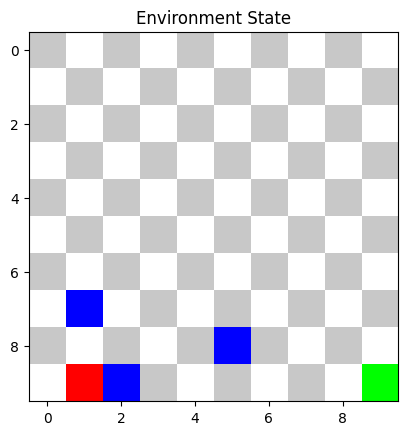

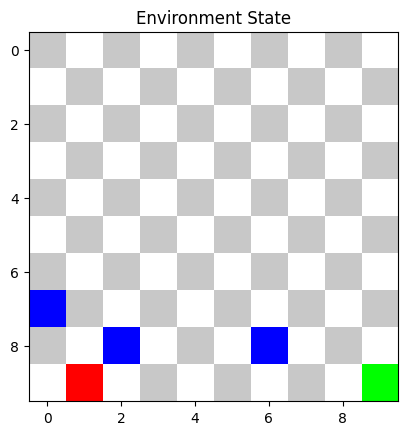

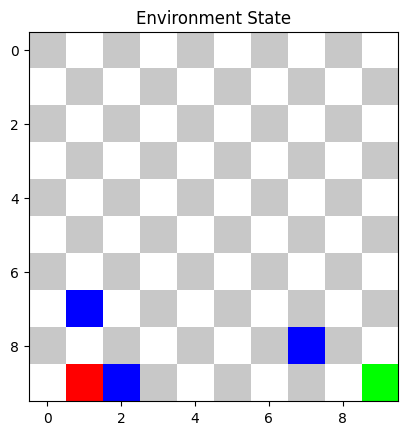

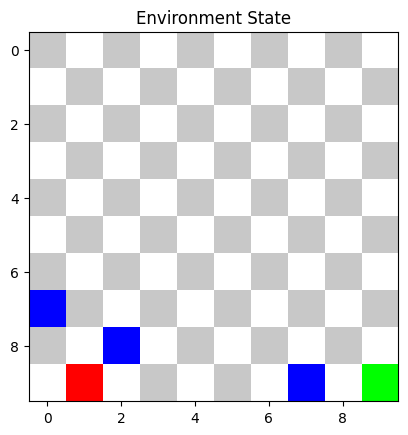

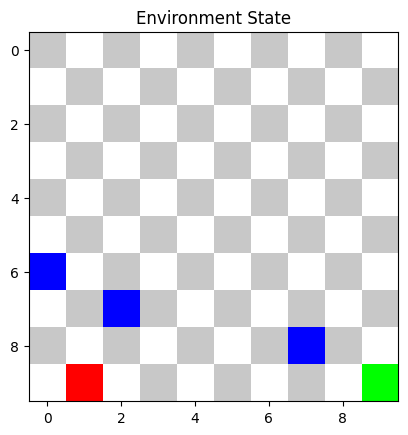

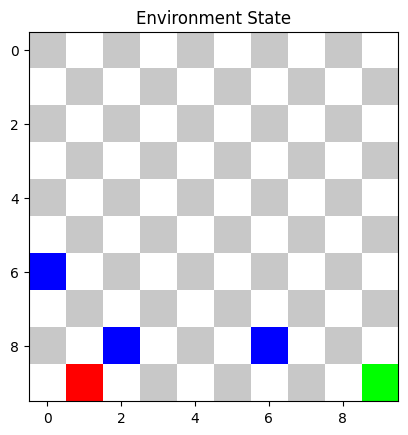

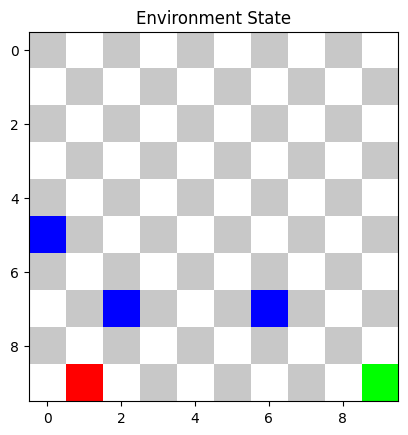

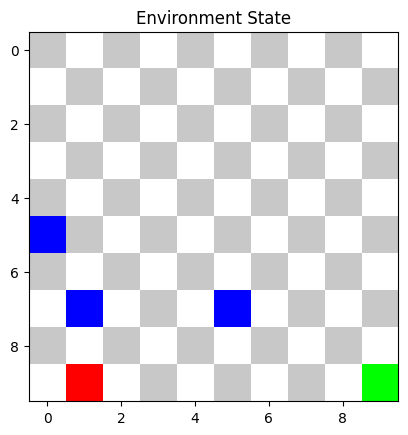

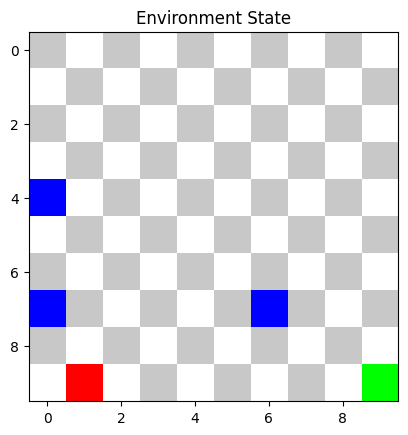

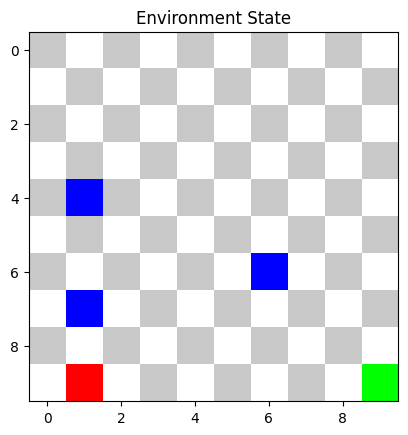

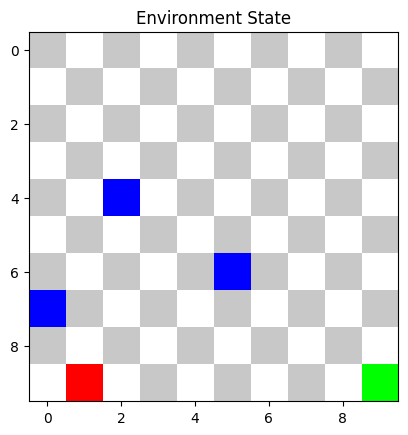

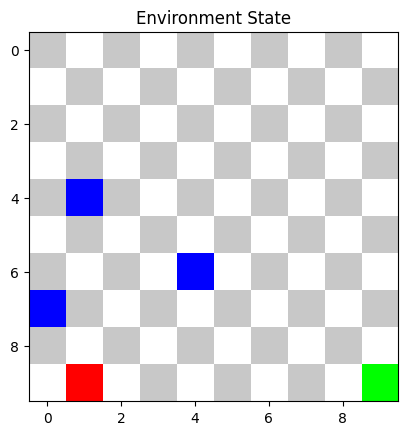

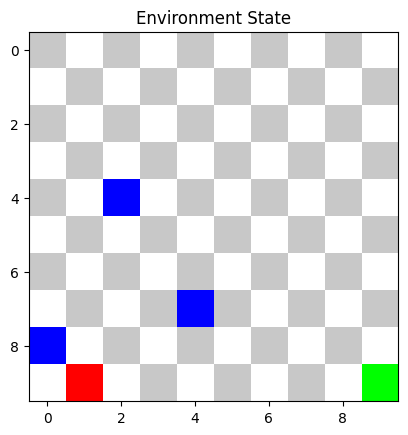

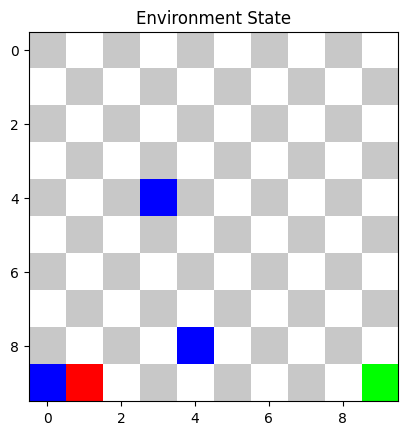

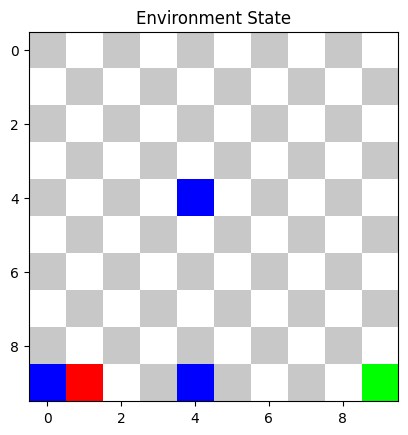

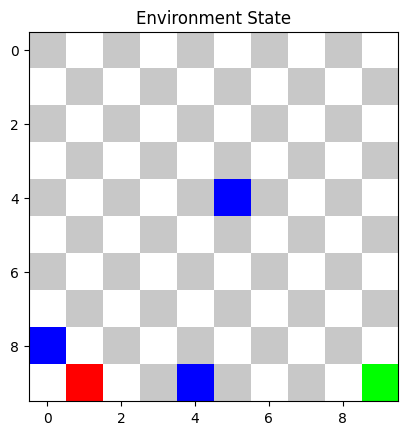

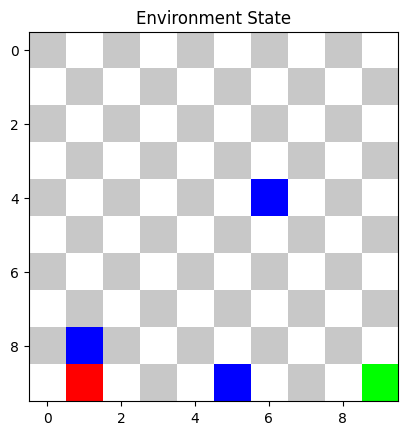

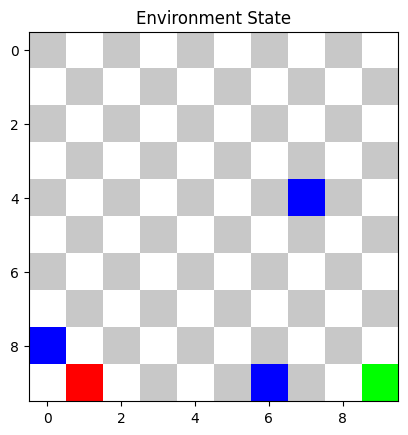

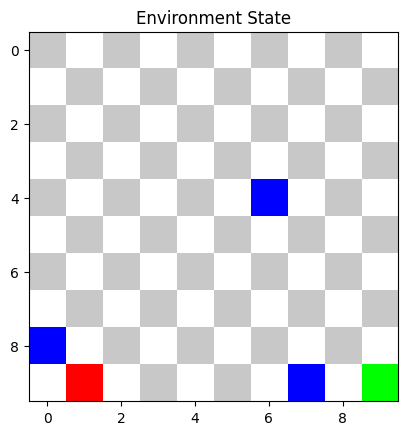

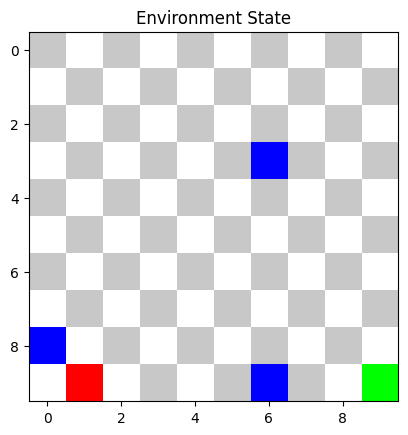

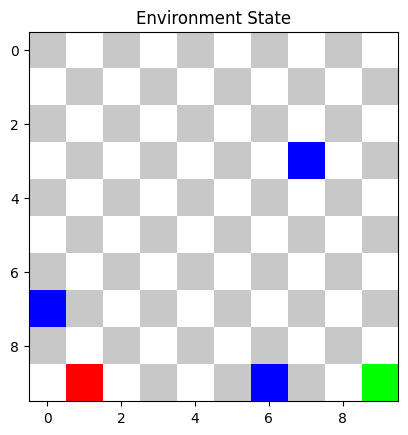

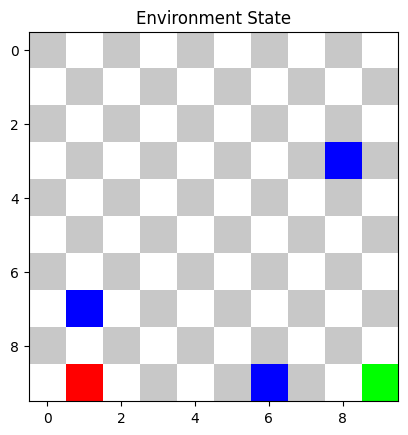

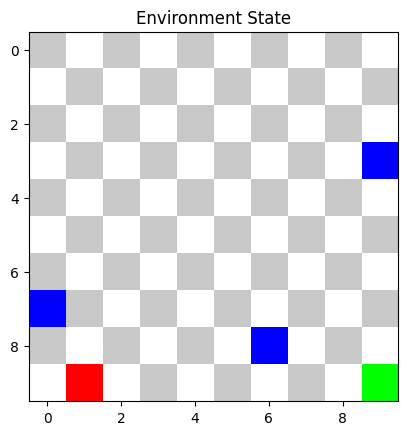

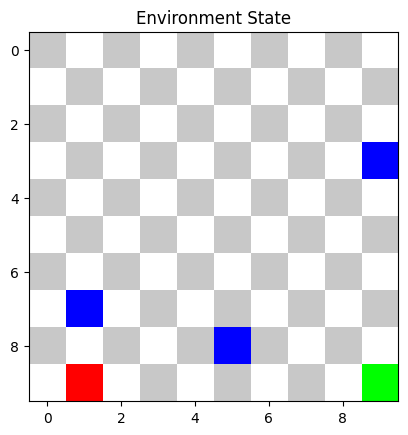

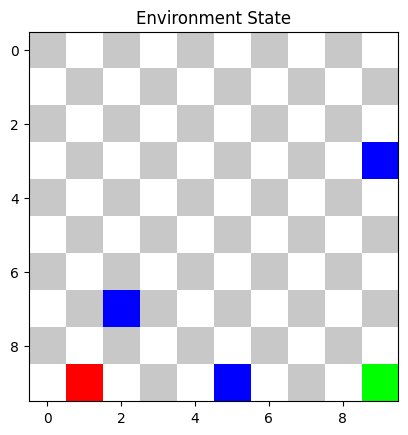

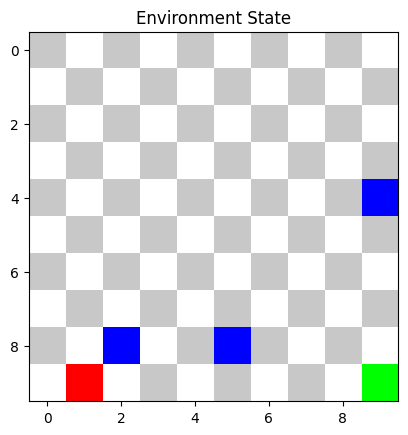

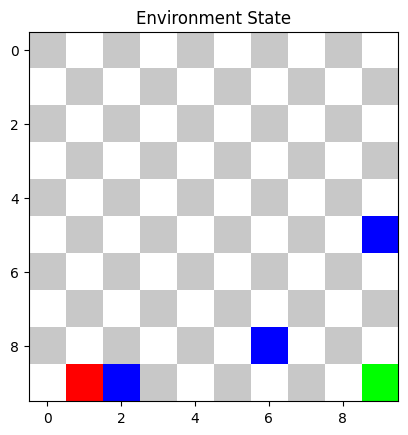

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Load the trained DQN model
model = DQN.load("dqn_dynamic_obstacles_best")  # Replace with your saved DQN model filename

# Create the custom environment
env = DynamicObstaclesEnv(grid_size=10, n_obstacles=3)

# Function to plot the state
def plot_state(state):
    plt.imshow(state)
    plt.title("Environment State")
    plt.pause(0.1)  # Pause a bit so that plots are updated


def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    successes = 0

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)
        if episode_reward > 0:  # Assuming positive reward indicates success
            successes += 1

    average_reward = sum(total_rewards) / num_episodes
    success_rate = successes / num_episodes

    return average_reward, success_rate

# Evaluate the model
average_reward, success_rate = evaluate_model(env, model, num_episodes=100)
print(f"Average Cumulative Reward: {average_reward}")
print(f"Success Rate: {success_rate}")


# Visualize the environment with the model
obs = env.reset()
done = False
plt.figure(figsize=(6, 6))
while not done:
    plot_state(env.render(mode='rgb_array'))  # Ensure your environment's render mode is 'rgb_array'
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)

plt.show()



# Proximal Policy Optimization (PPO) Implementation
Hyperparameter Tuning for PPO

This section includes the process of tuning hyperparameters for the PPO algorithm.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# Create the custom environment
env_fn = lambda: DynamicObstaclesEnv(grid_size=10, n_obstacles=3)
env = make_vec_env(env_fn, n_envs=1)

# Hyperparameters to try
learning_rates = [0.00025, 0.0001, 0.00005]
clip_ranges = [0.1, 0.2, 0.3]
batch_sizes = [64, 128, 256]

best_performance = -float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for clip_range in clip_ranges:
        for batch_size in batch_sizes:
            # Initialize the PPO model with specified hyperparameters
            model = PPO("MlpPolicy", env, learning_rate=lr, batch_size=batch_size, clip_range=clip_range, verbose=0)
            model.learn(total_timesteps=20000)

            # Evaluate the model
            mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
            print(f"LR: {lr}, Clip Range: {clip_range}, Batch Size: {batch_size}, Mean Reward: {mean_reward}")

            # Check if this is the best performing model
            if mean_reward > best_performance:
                best_performance = mean_reward
                best_hyperparameters = {'learning_rate': lr, 'clip_range': clip_range, 'batch_size': batch_size}

# Output the best hyperparameters
print(f"Best Hyperparameters for PPO: {best_hyperparameters}")

# Save the best performing model
model.save("ppo_dynamic_obstacles_best")


LR: 0.00025, Clip Range: 0.1, Batch Size: 64, Mean Reward: 63.9
LR: 0.00025, Clip Range: 0.1, Batch Size: 128, Mean Reward: -33.7
LR: 0.00025, Clip Range: 0.1, Batch Size: 256, Mean Reward: -9.2
LR: 0.00025, Clip Range: 0.2, Batch Size: 64, Mean Reward: 27.0
LR: 0.00025, Clip Range: 0.2, Batch Size: 128, Mean Reward: -58.5
LR: 0.00025, Clip Range: 0.2, Batch Size: 256, Mean Reward: -117.9
LR: 0.00025, Clip Range: 0.3, Batch Size: 64, Mean Reward: 32.6
LR: 0.00025, Clip Range: 0.3, Batch Size: 128, Mean Reward: -156.3
LR: 0.00025, Clip Range: 0.3, Batch Size: 256, Mean Reward: -63.3
LR: 0.0001, Clip Range: 0.1, Batch Size: 64, Mean Reward: -129.5
LR: 0.0001, Clip Range: 0.1, Batch Size: 128, Mean Reward: 53.9
LR: 0.0001, Clip Range: 0.1, Batch Size: 256, Mean Reward: -224.4
LR: 0.0001, Clip Range: 0.2, Batch Size: 64, Mean Reward: 4.5
LR: 0.0001, Clip Range: 0.2, Batch Size: 128, Mean Reward: -160.2
LR: 0.0001, Clip Range: 0.2, Batch Size: 256, Mean Reward: -45.0
LR: 0.0001, Clip Range:

# Model Evaluation and Visualization
Here, the trained PPO model is evaluated and visualized.

Average Cumulative Reward: 40.74
Success Rate: 0.75


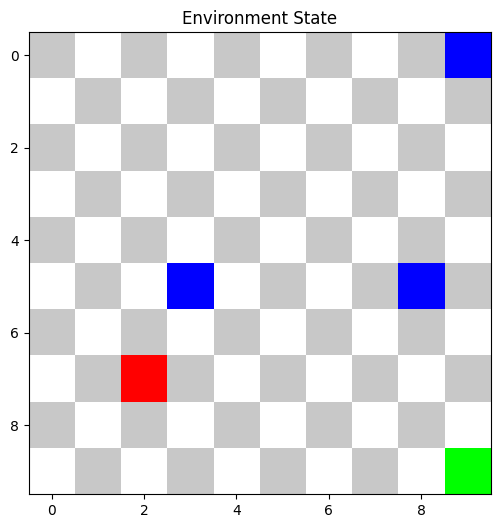

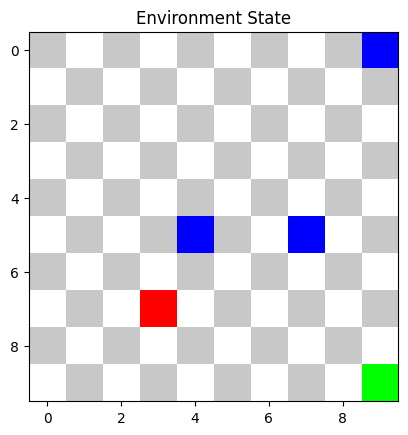

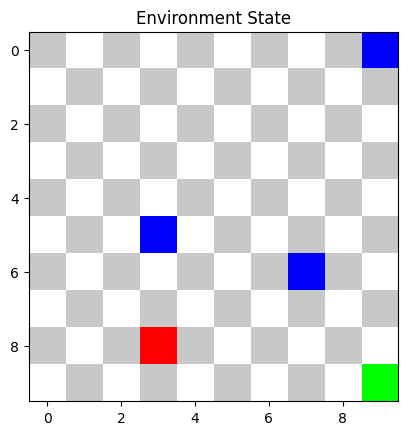

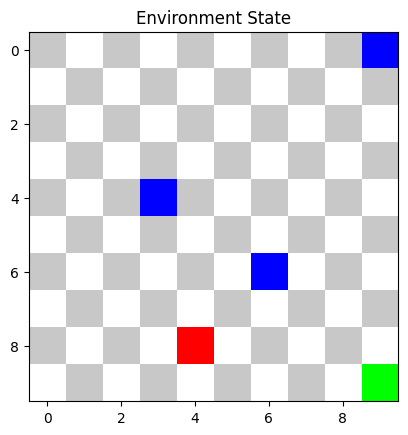

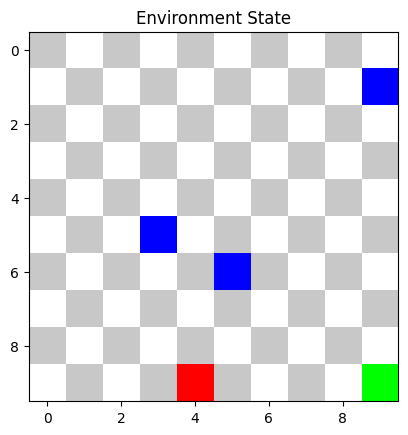

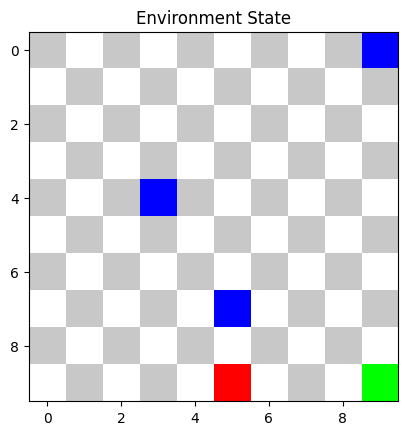

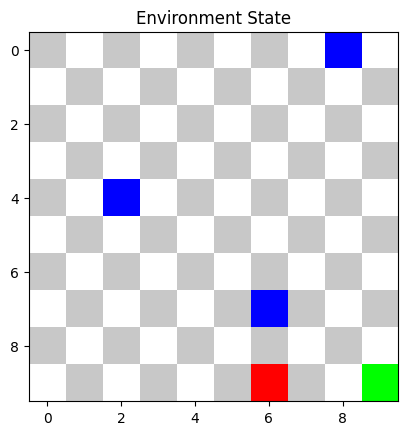

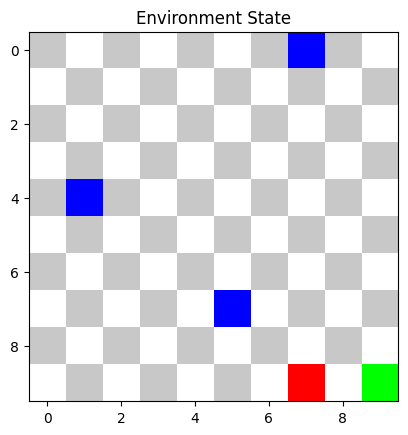

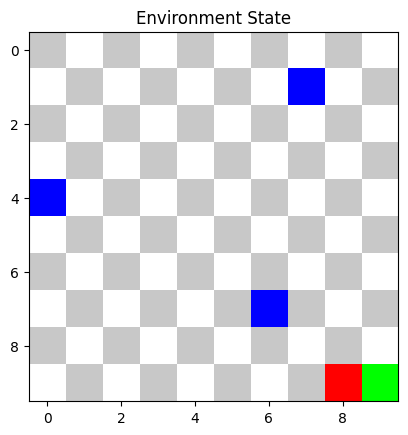

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Load the trained model
model = PPO.load("ppo_dynamic_obstacles_best")

# Create the custom environment
env = DynamicObstaclesEnv(grid_size=10, n_obstacles=3)

# Function to plot the state
def plot_state(state):
    plt.imshow(state)
    plt.title("Environment State")
    plt.pause(0.1)  # Pause a bit so that plots are updated

def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    successes = 0

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)
        if episode_reward > 0:  # Assuming positive reward indicates success
            successes += 1

    average_reward = sum(total_rewards) / num_episodes
    success_rate = successes / num_episodes

    return average_reward, success_rate

# Evaluate the model
average_reward, success_rate = evaluate_model(env, model, num_episodes=100)
print(f"Average Cumulative Reward: {average_reward}")
print(f"Success Rate: {success_rate}")

# Visualize the environment with the model
obs = env.reset()
done = False
plt.figure(figsize=(6, 6))
while not done:
    plot_state(env.render(mode='rgb_array'))  # Update this if your environment has a different render mode
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)

plt.show()


# Advantage Actor-Critic (A2C) Implementation

Training the A2C model using the custom environment.

In [ ]:
import gym
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# Create the custom environment
env = DynamicObstaclesEnv(grid_size=10, n_obstacles=3)

# Optionally, wrap it for vectorized environments
env = make_vec_env(lambda: env, n_envs=4)  # A2C benefits from multiple environments

# Initialize the A2C model
model = A2C("MlpPolicy", env, verbose=1)

# Train the model
train_steps = 20000  # Adjust the number of training steps
model.learn(total_timesteps=train_steps)

# Optionally, save the model
model.save("a2c_dynamic_obstacles")

# To load the model, use:
# model = A2C.load("a2c_dynamic_obstacles")


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 58.3     |
|    ep_rew_mean        | -120     |
| time/                 |          |
|    fps                | 1197     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.39    |
|    explained_variance | 0.0187   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.48    |
|    value_loss         | 7.58     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 58.2     |
|    ep_rew_mean        | -126     |
| time/                 |          |
|    fps                | 1554     |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 4000     |
| train/             

# Model Evaluation and Visualization
Evaluating and visualizing the performance of the A2C model.

Average Cumulative Reward: 62.48
Success Rate: 0.86


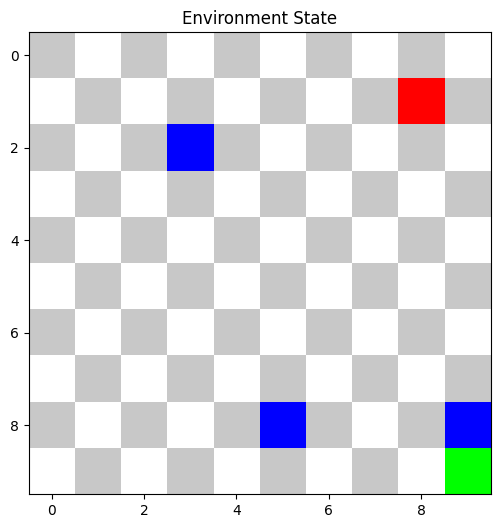

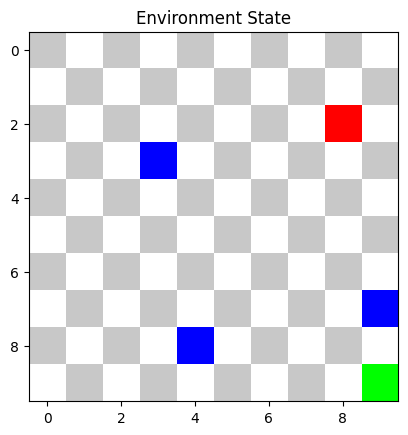

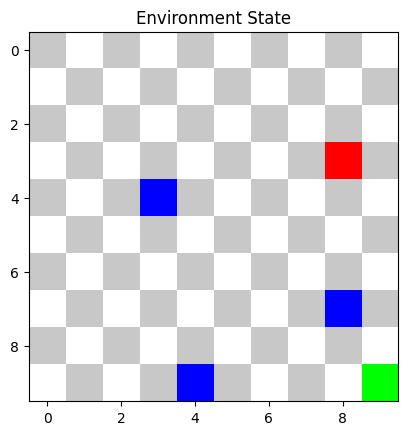

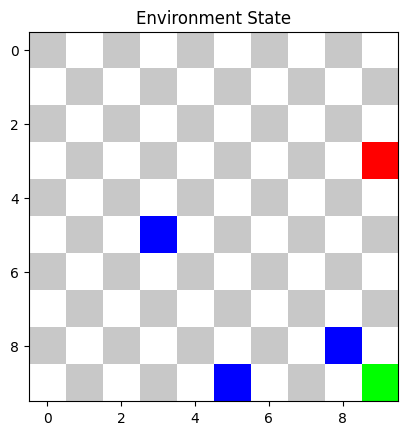

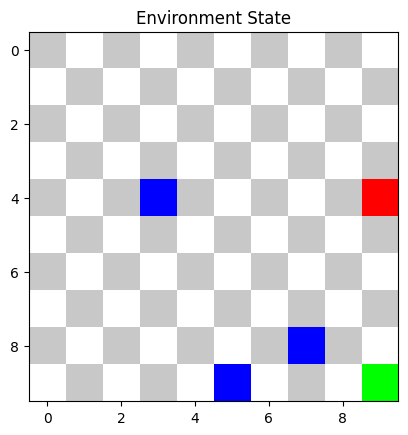

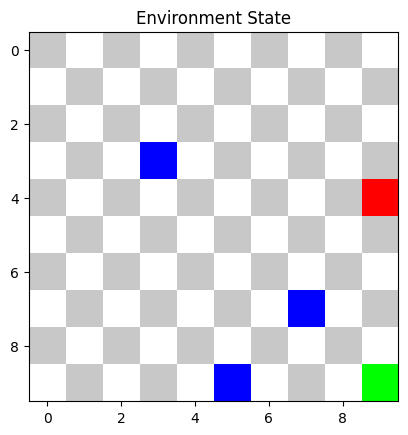

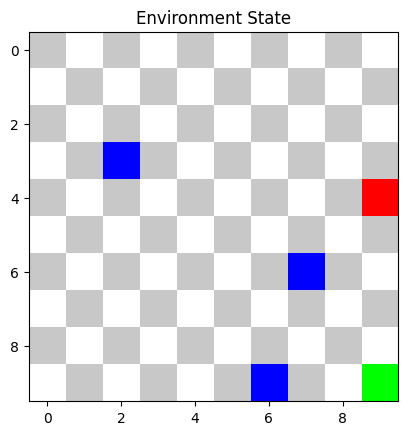

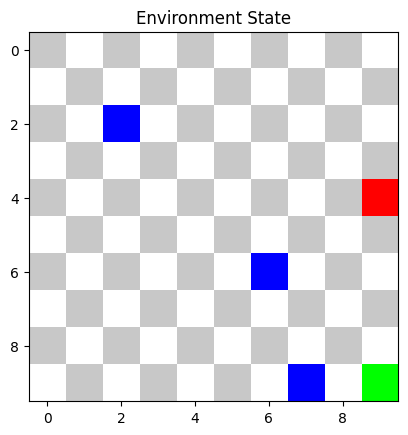

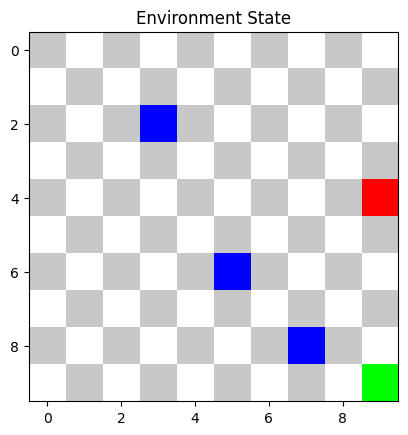

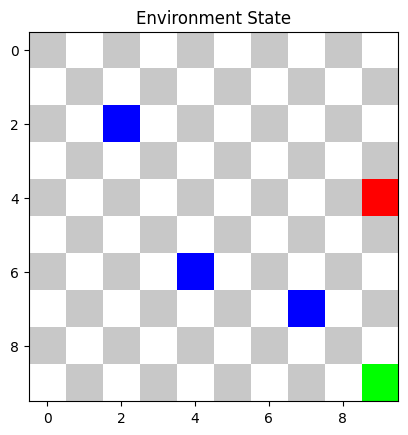

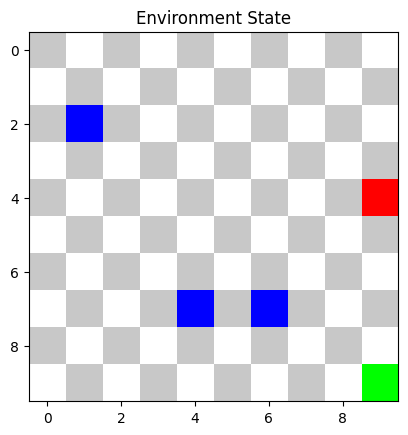

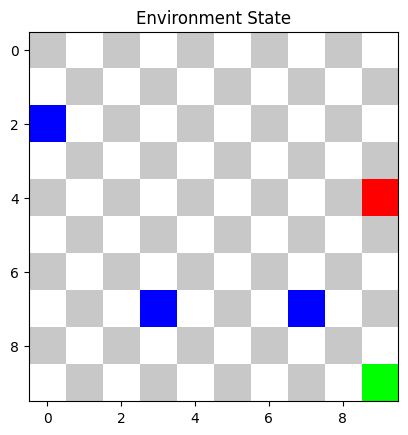

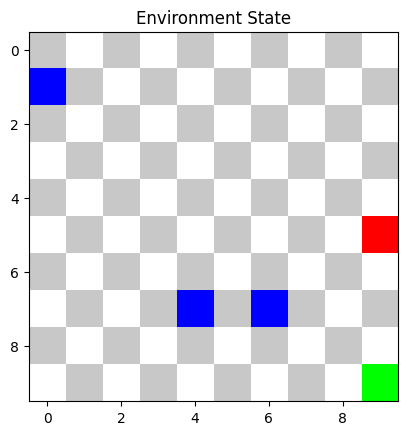

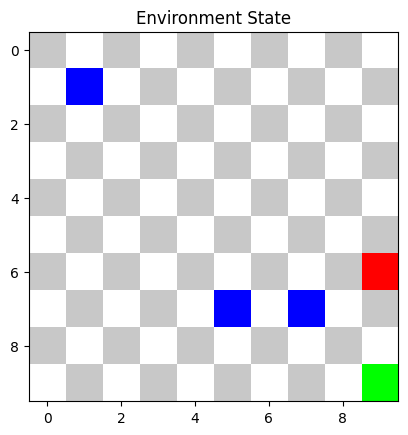

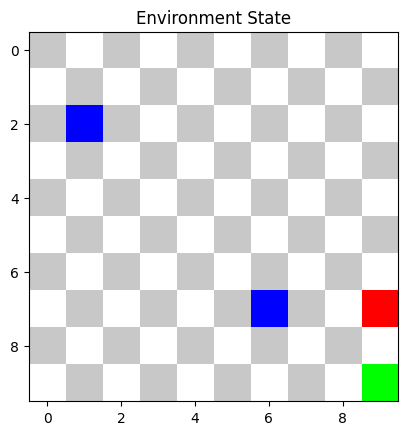

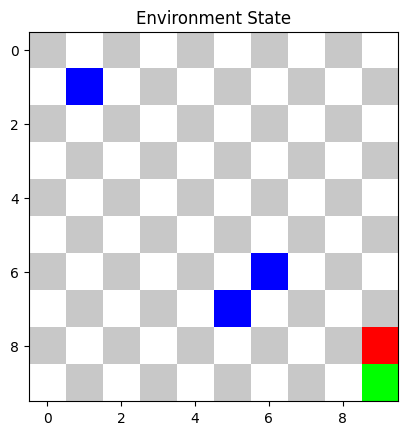

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import A2C

# Load the trained A2C model
model = A2C.load("a2c_dynamic_obstacles")  # Ensure this matches your saved A2C model filename

# Create the custom environment
env = DynamicObstaclesEnv(grid_size=10, n_obstacles=3)

# Function to plot the state
def plot_state(state):
    plt.imshow(state)
    plt.title("Environment State")
    plt.pause(0.1)  # Pause a bit so that plots are updated

def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    successes = 0

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)
        if episode_reward > 0:  # Assuming positive reward indicates success
            successes += 1

    average_reward = sum(total_rewards) / num_episodes
    success_rate = successes / num_episodes

    return average_reward, success_rate

# Evaluate the model
average_reward, success_rate = evaluate_model(env, model, num_episodes=100)
print(f"Average Cumulative Reward: {average_reward}")
print(f"Success Rate: {success_rate}")

# Visualize the environment with the model
obs = env.reset()
done = False
plt.figure(figsize=(6, 6))
while not done:
    plot_state(env.render(mode='rgb_array'))  # Ensure your environment's render mode is 'rgb_array'
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)

plt.show()


# Twin Delayed DDPG (TD3) Implementation
Training the TD3 model for the continuous action space environment.

In [ ]:
import gym
from stable_baselines3 import TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np

# Create the custom environment
env_fn = lambda: DynamicObstaclesEnvCont(grid_size=10, n_obstacles=3)

# Optionally, wrap it for vectorized environments
env = make_vec_env(env_fn, n_envs=1)

# Access action_space from one of the environments
n_actions = env_fn().action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize the TD3 model
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)

# Train the model
train_steps = 20000  # Adjust the number of training steps
model.learn(total_timesteps=train_steps)

# Optionally, save the model
model.save("td3_dynamic_obstacles")

# To load the model, use:
# model = TD3.load("td3_dynamic_obstacles")


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Streaming output truncated to the last 5000 lines.
|    actor_loss      | -42      |
|    critic_loss     | 391      |
|    learning_rate   | 0.001    |
|    n_updates       | 8014     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.73     |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    episodes        | 852      |
|    fps             | 44       |
|    time_elapsed    | 183      |
|    total_timesteps | 8106     |
| train/             |          |
|    actor_loss      | -43.7    |
|    critic_loss     | 365      |
|    learning_rate   | 0.001    |
|    n_updates       | 8035     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.48     |
|    ep_rew_mean     | 52.5     |
| time/              |          |
|    episodes        | 856      |
|    fps             | 44       |
|    time_elapsed    | 183     

# Model Evaluation and Visualization
Evaluating and visualizing the performance of the TD3 model.

Average Cumulative Reward: 79.2
Success Rate: 0.92


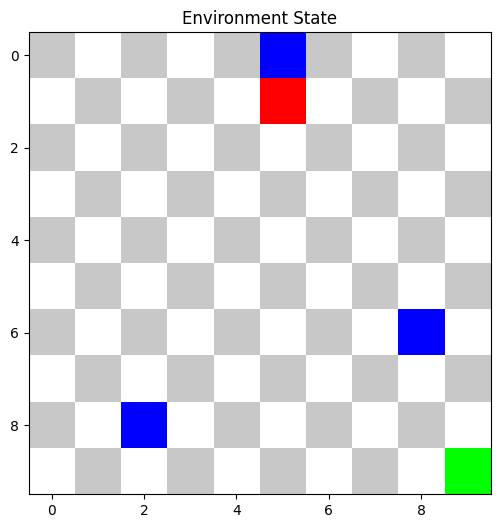

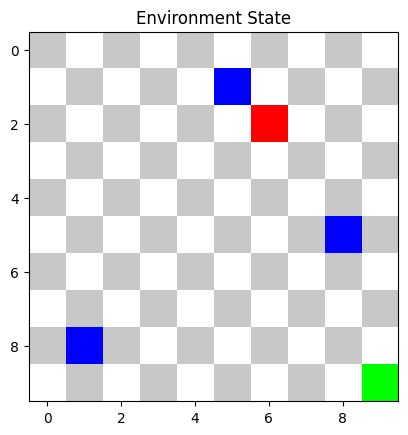

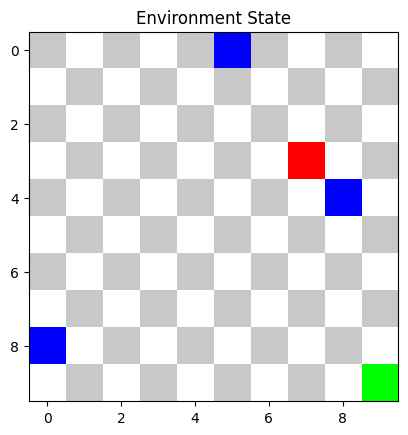

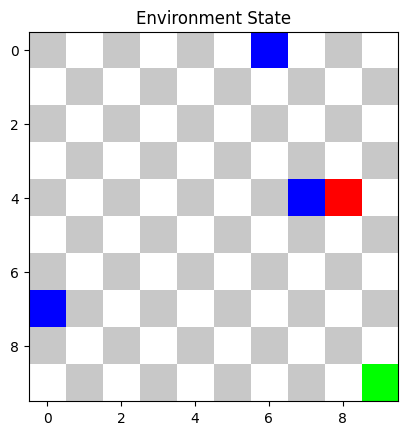

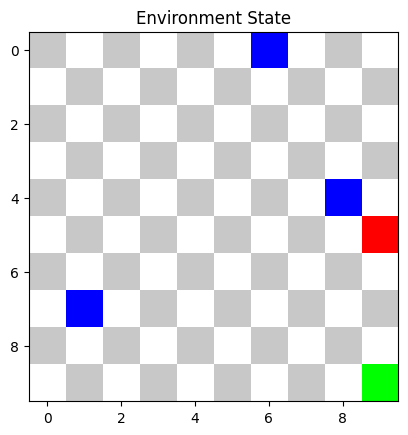

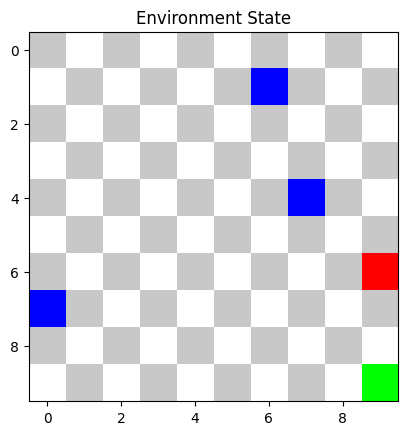

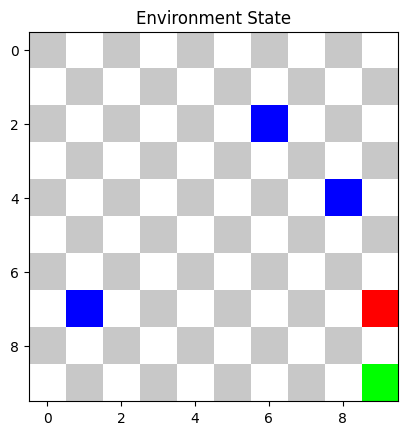

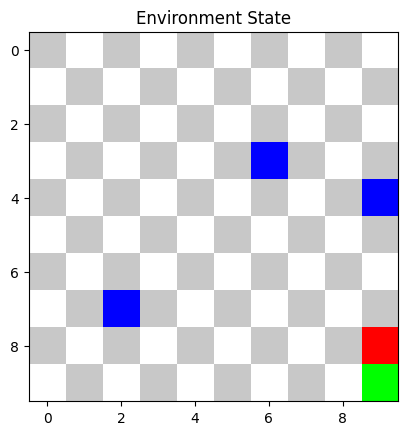

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import TD3

# Load the trained TD3 model
model = TD3.load("td3_dynamic_obstacles")  # Replace with your saved TD3 model filename

# Create the custom environment
env = DynamicObstaclesEnvCont(grid_size=10, n_obstacles=3)

# Function to plot the state
def plot_state(state):
    plt.imshow(state)
    plt.title("Environment State")
    plt.pause(0.1)  # Pause a bit so that plots are updated

def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    successes = 0

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)
        if episode_reward > 0:  # Assuming positive reward indicates success
            successes += 1

    average_reward = sum(total_rewards) / num_episodes
    success_rate = successes / num_episodes

    return average_reward, success_rate

# Evaluate the model
average_reward, success_rate = evaluate_model(env, model, num_episodes=100)
print(f"Average Cumulative Reward: {average_reward}")
print(f"Success Rate: {success_rate}")

# Visualize the environment with the model
obs = env.reset()
done = False
plt.figure(figsize=(6, 6))
while not done:
    plot_state(env.render(mode='rgb_array'))  # Ensure your environment's render mode is 'rgb_array'
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)

plt.show()
